In [ ]:
%pip install -q sentence-transformers==3.0.1 scikit-learn==1.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 44.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


In [ ]:
!pip install yfinance fredapi pandas textblob matplotlib fpdf seaborn transformers torch

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=f5f6cdacdaf870e8298c4ee1a826a13eec437f962a6bf7f0956ed4b913c1ac80
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [ ]:
#Import
import yfinance as yf
from yfinance.ticker import Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from textblob import TextBlob
from fpdf import FPDF
from IPython.display import display
import os, datetime, hashlib, json, warnings, string
import time
import requests
from bs4 import BeautifulSoup
import re
from transformers import pipeline
import torch

warnings.filterwarnings("ignore")

# Setup FRED
FRED_API_KEY = os.environ.get("FRED_API_KEY", "e9b13c9f61d9447309d4c104b82a45d1")
fred = Fred(api_key=FRED_API_KEY)
CONFIG = {"memory_dir": "memory", "report_dir": "reports"}

# Create necessary directories
os.makedirs(CONFIG["memory_dir"], exist_ok=True)
os.makedirs(CONFIG["report_dir"], exist_ok=True)

# Initialize LLM for synthesis
device = 0 if torch.cuda.is_available() else -1
synthesis_llm = pipeline("summarization", model="facebook/bart-large-cnn", device=device)

print("Setup complete. Configuration directories created/verified.")
print("FRED API initialized.")
print("LLM (BART) initialized for synthesis.")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Setup complete. Configuration directories created/verified.
FRED API initialized.
LLM (BART) initialized for synthesis.


In [ ]:
# DATA HANDLING, FETCHING, AND CORE ANALYSIS FUNCTIONS
# Persistent learning across runs — loads prior notes for a ticker to influence future analyses
def load_memory(ticker):
    """Loads a ticker's persistent notes/summary from a file."""
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    return json.load(open(path)) if os.path.exists(path) else {"notes": "No prior analysis", "last_run": None}

# Persistent learning across runs — saves notes/summary after each run to improve future analyses
def save_memory(ticker, data):
    """Saves a ticker's notes/summary for future runs."""
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    json.dump(data, open(path, "w"), indent=2)

# Dynamic tool use via Yahoo Finance API/dataset — fetches historical OHLCV and news for a ticker
def fetch_yfinance_data(ticker):
    """Tool: Fetches historical prices (1y) and news using yfinance."""
    print(f"    [Tool Use] Fetching yfinance data for {ticker}...")
    try:
        t = yf.Ticker(ticker)
        hist = t.history(period="1y").reset_index()
        news = t.news or []
        return hist, news
    except Exception as e:
        print(f"        [Error] Failed to fetch yfinance data for {ticker}: {e}")
        return pd.DataFrame(), []

# Dynamic tool use via FRED API — fetches macroeconomic time series (e.g., CPIAUCSL)
def fetch_fred_data(series_id):
    """Tool: Fetches economic data using FRED API (e.g., CPIAUCSL)."""
    try:
        s = fred.get_series(series_id)
        if s is None or s.empty:
            return pd.DataFrame()
        df = pd.DataFrame(s).reset_index()
        data_col_name = df.columns[-1]
        df.rename(columns={data_col_name: series_id, 'index': 'date'}, inplace=True)
        return df
    except Exception as e:
        print(f"        Error fetching FRED data: {e}")
        return pd.DataFrame()

# Dynamic tool — technical indicator for price analysis (RSI)
def compute_rsi(series, window=14):
    """Tool: Computes Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rsi = 100 - (100 / (1 + gain / loss))
    return rsi

# Prompt Chaining — Preprocess, Classify, Extract news via weighted sentiment & tone
def news_impact_analyzer(news_list, ticker):
    """Workflow: Sentiment analysis with simulated NER/POS filtering."""
    results = []
    high_impact_keywords = ["acquire", "launch", "missed", "soared", "failed", "record", "major"]
    for n in news_list:
        t = n.get("title", "").lower()
        if t:
            s = TextBlob(t).sentiment.polarity
            is_high_impact = any(k in t for k in high_impact_keywords) and ticker.lower() in t.lower()
            sentiment_weight = 1.0 if is_high_impact else 0.5
            weighted_s = s * sentiment_weight
            tone = "positive" if weighted_s > 0.1 else "negative" if weighted_s < -0.1 else "neutral"
            results.append({"title": n.get("title", ""), "sentiment": round(s, 2), "weighted_sentiment": round(weighted_s, 2), "tone": tone})
    df = pd.DataFrame(results)
    overall_sentiment = df['weighted_sentiment'].mean() if not df.empty else 0
    return df, overall_sentiment

In [ ]:
# VISUALIZATION FUNCTIONS
from IPython.display import Image, display

# Dynamic tool — visualization function for price & RSI evidence in the report
def plot_price_and_rsi(df, ticker, rsi):
    """Tool: Plots stock price and RSI and saves the image."""
    if df.empty or rsi.empty:
        return None
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax1.plot(df["Date"], df["Close"], label="Close", color='darkblue', linewidth=1.5)
    ax1.plot(df["Date"], df["Close"].rolling(50).mean(), label="MA-50", color='orange', linestyle='--')
    ax1.plot(df["Date"], df["Close"].rolling(200).mean(), label="MA-200", color='red', linestyle='--')
    ax1.set_title(f"{ticker} Price and Moving Averages", fontsize=14)
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='y', labelcolor='darkblue')
    ax2.plot(df["Date"], rsi, label="RSI-14", color="purple", linewidth=1.5)
    ax2.axhline(70, color='red', linestyle="--", alpha=0.7, label="Overbought")
    ax2.axhline(30, color='green', linestyle="--", alpha=0.7, label="Oversold")
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.set_title("RSI Trends", fontsize=14)
    ax2.set_xlabel("Date")
    path = f"{CONFIG['report_dir']}/{ticker}_price_rsi.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    print(f"        [Chart] Generated Price & RSI chart: {os.path.basename(path)}")
    return path

# Dynamic tool — visualization of macro correlation (e.g., CPI vs price)
def plot_macro_correlation(stock_df, macro_df, ticker, macro_key):
    """Tool: Plots price vs macro indicator, returns correlation, and saves the image."""
    stock_df_fixed = stock_df.copy()
    if pd.api.types.is_datetime64_any_dtype(stock_df_fixed["Date"]) and stock_df_fixed["Date"].dt.tz is not None:
        stock_df_fixed["Date"] = stock_df_fixed["Date"].dt.tz_localize(None)
    merged = pd.merge(stock_df_fixed, macro_df, left_on="Date", right_on="date", how="inner")
    if merged.empty or len(merged) < 5:
        return None, None
    corr = merged[["Close", macro_key]].corr().iloc[0, 1]
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(merged["Date"], merged["Close"], label=f"{ticker} Close", color="blue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"{ticker} Close Price", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()
    ax2.plot(merged["date"], merged[macro_key], label=macro_key.upper(), color="orange", linestyle="--")
    ax2.set_ylabel(macro_key.upper(), color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")
    plt.title(f"{ticker} vs {macro_key.upper()} (Correlation: {corr:.2f})", fontsize=14)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    path = f"{CONFIG['report_dir']}/{ticker}_{macro_key}_corr.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    print(f"        [Chart] Generated Macro Correlation chart: {os.path.basename(path)}")
    return path, corr

# Dynamic tool — visualization of **Classify** stage (sentiment distribution)
def plot_sentiment_distribution(df, ticker):
    """Tool: Plots news sentiment distribution and saves the image."""
    if df.empty:
        return None
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(5, 4))
    colors = ['green' if x == 'positive' else 'red' if x == 'negative' else 'gray' for x in df["tone"].value_counts().index]
    df["tone"].value_counts().plot(kind="bar", color=colors, alpha=0.7)
    plt.title(f"News Sentiment Distribution ({ticker})", fontsize=14)
    plt.xticks(rotation=0, ha='center')
    plt.ylabel("Number of Articles")
    plt.xlabel("Sentiment Tone")
    path = f"{CONFIG['report_dir']}/{ticker}_sentiment.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()
    print(f"        [Chart] Generated Sentiment chart: {os.path.basename(path)}")
    return path

In [ ]:
# SPECIALIST AGENT CLASSES
# PriceAnalyzer Agent: PriceAnalyzer handles RSI & trend regime
class PriceAnalyzer:
    """Specialist: Analyzes price data, calculating RSI and trend regime."""
    def analyze(self, hist):
        if hist.empty or "Close" not in hist.columns or len(hist) < 20:
            print("        [Warning] PriceAnalyzer received insufficient historical data.")
            return {"rsi": None, "regime": "N/A (Data Unavailable)"}
        rsi = compute_rsi(hist["Close"])
        if rsi.empty or rsi.iloc[-1].item() is np.nan:
            rsi_value = None
            regime = "N/A (Insufficient Data)"
        else:
            rsi_value = rsi.iloc[-1].item()
            ma_20 = hist["Close"].rolling(20).mean().iloc[-1]
            regime = "Uptrend" if hist["Close"].iloc[-1] > ma_20 else "Downtrend"
        return {"rsi": rsi_value, "regime": regime}

# MacroAnalyzer Agent handles FRED macro signal & correlations
class MacroAnalyzer:
    """Specialist: Analyzes macro-economic data and correlation (default: CPI)."""
    def analyze(self, hist, ticker, macro_key="CPIAUCSL"):
        macro = fetch_fred_data(macro_key)
        path, corr = plot_macro_correlation(hist, macro, ticker, macro_key)
        return {"corr": corr, "plot_path": path}

# NewsAnalyzer Agent computes weighted sentiment & tone
class NewsAnalyzer:
    """Specialist: Analyzes news sentiment using the weighted scoring logic."""
    def analyze(self, news, ticker):
        df, sentiment = news_impact_analyzer(news, ticker)
        return {"sentiment": sentiment, "news_df": df, "num_news": len(df)}

# NewsSummarizer Agent: Ingest (fetch) → Preprocess/clean → Summarize news articles
class NewsSummarizer:
    """Specialist: Summarizes news articles for a ticker."""
    def __init__(self, summarizer, ticker):
        self.summarizer = summarizer
        self.ticker = ticker
        self.content_list = []
        self.content_summaries = []
        self.meta_summary = None

# Ingest & Preprocess — pulls article pages, strips HTML, normalizes text
    def fetch_and_clean(self):
        """Fetches and cleans news articles."""
        _, news = fetch_yfinance_data(self.ticker.ticker)
        for article in news:
            try:
                response = requests.get(article.get("link", ""), timeout=5)
                soup = BeautifulSoup(response.text, 'html.parser')
                text = ' '.join(p.get_text() for p in soup.find_all('p'))
                text = re.sub(r'\s+', ' ', text).strip()
                if text and len(text) > 50:
                    self.content_list.append(text[:1000])
            except:
                continue

# Summarize — distills multi‑article content into concise meta‑summary via LLM
    def summarize(self):
        """Summarizes articles and generates meta-summary."""
        self.fetch_and_clean()
        for content in self.content_list:
            try:
                summary = self.summarizer(content, max_length=60, min_length=20, do_sample=False)[0]['summary_text']
                self.content_summaries.append(summary)
            except:
                continue
        if self.content_summaries:
            combined = " ".join(self.content_summaries)
            self.meta_summary = self.summarizer(combined, max_length=100, min_length=40, do_sample=False)[0]['summary_text']
        return self.meta_summary

In [ ]:
# AGENT AND PROMPT MANAGER
from IPython.display import Image, display

# Routing workflow — directs request to single‑ticker vs two‑ticker pipelines and downstream specialists
class PromptManager:
    """Manages prompt execution and routing to specialists or LLM."""
    def __init__(self, agent):
        self.agent = agent

    def execute_prompt(self, prompt, ticker=None, ticker2=None):
        print(f"\nProcessing prompt: {prompt}")
        if ticker and ticker2:
            result1 = self.agent.analyze_ticker(ticker)
            result2 = self.agent.analyze_ticker(ticker2)
            self.agent.synthesize_comparison(prompt, ticker, result1, ticker2, result2)
        elif ticker:
            result = self.agent.analyze_ticker(ticker)
            self.agent.synthesize_response(prompt, ticker, result)

class InvestmentResearchAgent:
    """Autonomous Investment Research Agent coordinating specialists and LLM."""
    def __init__(self):
        self.price_analyzer = PriceAnalyzer()
        self.macro_analyzer = MacroAnalyzer()
        self.news_analyzer = NewsAnalyzer()
        self.news_summarizer = NewsSummarizer(synthesis_llm, yf.Ticker)
        self.llm = synthesis_llm

# Planning research steps — orchestrates sequence: load memory → fetch data → run specialists → summarize → visualize → persist
    def analyze_ticker(self, ticker):
        """Analyzes a single ticker using specialists."""
        print(f"Analyzing {ticker}...")
        memory = load_memory(ticker)
        print(f"    [Agent Learns] Prior Notes ({memory['last_run']}): {memory['notes']}")
        hist, news = fetch_yfinance_data(ticker)
        price_result = self.price_analyzer.analyze(hist)
        macro_result = self.macro_analyzer.analyze(hist, ticker)
        news_result = self.news_analyzer.analyze(news, ticker)
        sentiment_plot = plot_sentiment_distribution(news_result['news_df'], ticker)
        self.news_summarizer.ticker = yf.Ticker(ticker)
        summary = self.news_summarizer.summarize()
        # Generate Price & RSI chart
        rsi = compute_rsi(hist["Close"]) if not hist.empty else pd.Series()
        price_rsi_plot = plot_price_and_rsi(hist, ticker, rsi)
        # Display charts inline
        print(f"\n============================================================\n"
              f"               📊 Final Investment Report for {ticker}\n"
              f"============================================================\n"
              f"💡 Key Findings:\n"
              f"  - Current RSI (14): {price_result['rsi'] or 'N/A'}, Regime: {price_result['regime']}\n"
              f"  - Macro Correlation (CPI): {macro_result['corr'] or 'N/A'}\n"
              f"  - News Sentiment (Weighted): {news_result['sentiment']:.2f} from {news_result['num_news']} articles\n"
              f"\n📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)\n"
              f"  - Data Summary: RSI is {price_result['rsi'] or 'N/A'}, Trend: {price_result['regime']}. "
              f"CPI Correlation: {macro_result['corr'] or 'N/A'}. Weighted News Sentiment: {news_result['sentiment']:.2f}.\n")
        print("📈 Visual Evidence:")
        if price_rsi_plot:
            print(f"  Displaying: {os.path.basename(price_rsi_plot)}")
            display(Image(filename=price_rsi_plot))
        if macro_result['plot_path']:
            print(f"  Displaying: {os.path.basename(macro_result['plot_path'])}")
            display(Image(filename=macro_result['plot_path']))
        if sentiment_plot:
            print(f"  Displaying: {os.path.basename(sentiment_plot)}")
            display(Image(filename=sentiment_plot))
        print("============================================================\n")
        result = {
            "price": price_result,
            "macro": macro_result,
            "news": news_result,
            "summary": summary,
            "sentiment_plot": sentiment_plot,
            "price_rsi_plot": price_rsi_plot,
            "memory": memory
        }
        save_memory(ticker, {"notes": summary or "No summary", "last_run": str(datetime.datetime.now())})
        return result

# Self‑reflection & Evaluator‑Optimizer — generate analysis, score confidence, use prior notes for feedback/refinement
    def synthesize_response(self, prompt, ticker, result):
        """Generates response using LLM for a single ticker."""
        print(f"SynthesisAgent (LLM) Generating Response...")
        input_text = (
            f"Prompt: {prompt}\n"
            f"Ticker: {ticker}\n"
            f"RSI: {result['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result['price']['regime']}\n"
            f"Macro Correlation (CPI): {result['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result['news']['sentiment']:.2f}\n"
            f"News Summary: {result['summary'] or 'No summary'}\n"
            f"Prior Notes: {result['memory']['notes']}\n"
            f"Generate a concise analysis with a confidence score (0-1) and key insights."
        )
        try:
            llm_output = self.llm(input_text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
            confidence = float(re.search(r'Confidence: (\d\.\d+)', llm_output).group(1)) if re.search(r'Confidence: (\d\.\d+)', llm_output) else 0.5
            print(f"\n============================================================\n"
                  f"             ✨ Final User-Facing Response ✨\n"
                  f"============================================================\n"
                  f"### Comprehensive Summary for {ticker}\n"
                  f"**Agent Confidence:** {confidence}\n\n"
                  f"**Key Analytical Insights:**\n"
                  f"{llm_output}\n"
                  f"\n**Agent Data Conclusion:** *RSI is {result['price']['rsi'] or 'N/A'}, "
                  f"Trend: {result['price']['regime']}. CPI Correlation: {result['macro']['corr'] or 'N/A'}. "
                  f"Weighted News Sentiment: {result['news']['sentiment']:.2f}.*\n"
                  f"============================================================\n")
            return {"text": llm_output, "confidence": confidence}
        except Exception as e:
            print(f"LLM synthesis failed: {e}")
            return {"text": "Analysis failed", "confidence": 0.5}

# Routing + Evaluator‑Optimizer for pairwise comparison (two specialists pipelines, then LLM synthesis)
    def synthesize_comparison(self, prompt, ticker1, result1, ticker2, result2):
        """Generates comparison using LLM for two tickers."""
        print(f"SynthesisAgent (LLM) Generating Response...")
        input_text = (
            f"Prompt: {prompt}\n"
            f"Ticker 1: {ticker1}\n"
            f"RSI: {result1['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result1['price']['regime']}\n"
            f"Macro Correlation (CPI): {result1['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result1['news']['sentiment']:.2f}\n"
            f"News Summary: {result1['summary'] or 'No summary'}\n"
            f"Ticker 2: {ticker2}\n"
            f"RSI: {result2['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result2['price']['regime']}\n"
            f"Macro Correlation (CPI): {result2['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result2['news']['sentiment']:.2f}\n"
            f"News Summary: {result2['summary'] or 'No summary'}\n"
            f"Compare the two tickers, provide a confidence score (0-1), and highlight strengths."
        )
        try:
            llm_output = self.llm(input_text, max_length=200, min_length=80, do_sample=False)[0]['summary_text']
            confidence = float(re.search(r'Confidence: (\d\.\d+)', llm_output).group(1)) if re.search(r'Confidence: (\d\.\d+)', llm_output) else 0.5
            print(f"\n============================================================\n"
                  f"             ✨ Final User-Facing Response ✨\n"
                  f"============================================================\n"
                  f"### Comparative Analysis: {ticker1} vs {ticker2}\n"
                  f"**Query Intent:** Comparison (Address: *{prompt}*)\n")
            display(pd.DataFrame({
                "Metric": ["Agent Confidence", "RSI (14)", "Price Regime", "Macro Corr (CPI)", "Weighted Sentiment"],
                ticker1: [confidence, result1['price']['rsi'] or 'N/A', result1['price']['regime'], result1['macro']['corr'] or 'N/A', result1['news']['sentiment']],
                ticker2: [confidence, result2['price']['rsi'] or 'N/A', result2['price']['regime'], result2['macro']['corr'] or 'N/A', result2['news']['sentiment']]
            }))
            print(f"\n**Synthesis Conclusion:**\n{llm_output}\n")

            # Display charts for both tickers
            print("📈 Visual Evidence:")
            if result1['price_rsi_plot']:
                print(f"  Displaying: {os.path.basename(result1['price_rsi_plot'])}")
                display(Image(filename=result1['price_rsi_plot']))
            if result1['macro']['plot_path']:
                print(f"  Displaying: {os.path.basename(result1['macro']['plot_path'])}")
                display(Image(filename=result1['macro']['plot_path']))
            if result1['sentiment_plot']:
                print(f"  Displaying: {os.path.basename(result1['sentiment_plot'])}")
                display(Image(filename=result1['sentiment_plot']))
            if result2['price_rsi_plot']:
                print(f"  Displaying: {os.path.basename(result2['price_rsi_plot'])}")
                display(Image(filename=result2['price_rsi_plot']))
            if result2['macro']['plot_path']:
                print(f"  Displaying: {os.path.basename(result2['macro']['plot_path'])}")
                display(Image(filename=result2['macro']['plot_path']))
            if result2['sentiment_plot']:
                print(f"  Displaying: {os.path.basename(result2['sentiment_plot'])}")
                display(Image(filename=result2['sentiment_plot']))
            print("============================================================\n")
            return {"text": llm_output, "confidence": confidence}
        except Exception as e:
            print(f"LLM comparison failed: {e}")
            return {"text": "Comparison failed", "confidence": 0.5}

In [ ]:
# RAG Setup
import os, json, numpy as np
from typing import List, Dict, Any
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    raise RuntimeError("Please run the setup cell to install sentence-transformers.") from e
from sklearn.neighbors import NearestNeighbors

class RAGStore:
    """
    Lightweight local RAG index: stores docs + embeddings on disk and retrieves with cosine similarity.
    Path layout:
      <base_path>/docs.json
      <base_path>/embeddings.npy
    """
    def __init__(self, base_path: str, model_name: str = "all-MiniLM-L6-v2"):
        self.base_path = base_path
        os.makedirs(self.base_path, exist_ok=True)
        self.docs_path = os.path.join(self.base_path, "docs.json")
        self.vecs_path = os.path.join(self.base_path, "embeddings.npy")
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
        self.docs: List[Dict[str, Any]] = []
        self.vecs = None
        self.nn = None
        if os.path.exists(self.docs_path) and os.path.exists(self.vecs_path):
            try:
                with open(self.docs_path, "r", encoding="utf-8") as f:
                    self.docs = json.load(f)
                self.vecs = np.load(self.vecs_path)
                if len(self.docs) == len(self.vecs):
                    self.nn = NearestNeighbors(metric="cosine").fit(self.vecs)
            except Exception:
                self.docs, self.vecs, self.nn = [], None, None

    def _save(self):
        with open(self.docs_path, "w", encoding="utf-8") as f:
            json.dump(self.docs, f, ensure_ascii=False, indent=2)
        if self.vecs is not None:
            np.save(self.vecs_path, self.vecs)

    def upsert(self, docs: List[Dict[str, Any]], text_key: str = "text", id_key: str = "id"):
        existing = {d.get(id_key) for d in self.docs if id_key in d}
        new_docs = [d for d in docs if d.get(id_key) not in existing]
        if not new_docs:
            return 0
        texts = [d.get(text_key, "") or "" for d in new_docs]
        if not any(texts):
            return 0
        new_vecs = self.model.encode(texts, normalize_embeddings=True)
        self.docs.extend(new_docs)
        self.vecs = new_vecs if self.vecs is None else np.vstack([self.vecs, new_vecs])
        self.nn = NearestNeighbors(metric="cosine").fit(self.vecs)
        self._save()
        return len(new_docs)

    def retrieve(self, query: str, k: int = 8):
        if not self.nn or self.vecs is None or not len(self.docs):
            return []
        qv = self.model.encode([query], normalize_embeddings=True)
        k = min(k, len(self.docs))
        dists, idxs = self.nn.kneighbors(qv, n_neighbors=k)
        return [self.docs[i] for i in idxs[0]]

def news_to_rag_docs(news_list: List[Dict[str, Any]], ticker: str) -> List[Dict[str, Any]]:
    docs = []
    for i, n in enumerate(news_list or []):
        doc_id = n.get("uuid") or n.get("id") or n.get("link") or f"{ticker}-{i}"
        title = n.get("title") or n.get("headline") or "(no title)"
        text = n.get("text") or n.get("content") or n.get("summary") or title
        meta = {
            "ticker": ticker,
            "publisher": n.get("publisher"),
            "published": n.get("providerPublishTime") or n.get("published"),
            "link": n.get("link"),
        }
        docs.append({"id": doc_id, "title": title, "text": str(text), "meta": meta})
    return docs


In [ ]:
# News Summarizer with RAG
from typing import Optional

def summarize_news_with_rag(bart_pipeline, ticker: str, base_dir: str = "memory", task: str = "investor briefing", fallback_fn=None) -> Optional[str]:
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    ctx = rag.retrieve(f"{ticker} catalysts guidance regulation litigation product launches earnings macro linkages", k=8)
    if not ctx:
        if callable(fallback_fn):
            return fallback_fn(ticker)
        return None
    context = "\n\n".join([f"[{i+1}] {d['title']}\n{d['text'][:1200]}" for i, d in enumerate(ctx)])
    prompt = (
        f"Summarize recent news for {ticker} for {task}. "
        f"Focus on catalysts, risks, guidance, litigation/regulatory, and timeline. "
        f"Use ONLY the CONTEXT below; be concise.\n\nCONTEXT:\n{context}\n\nBRIEFING:"
    )
    try:
        out = bart_pipeline(prompt, max_length=350, do_sample=False)
        return out[0]["summary_text"]
    except Exception:
        return None

try:
    class NewsSummarizerRAG(NewsSummarizer):

# Summarize — distills multi‑article content into concise meta‑summary via LLM
        def summarize(self, ticker: str, *args, **kwargs):
            fb = getattr(super(), "summarize", None)
            return summarize_news_with_rag(self.pipeline, ticker, fallback_fn=fb)
except NameError:
    class NewsSummarizerRAG:
        def __init__(self, pipeline):
            self.pipeline = pipeline
        def summarize(self, ticker: str, *_, **__):
            return summarize_news_with_rag(self.pipeline, ticker)

In [ ]:
# Sentiment / Impact prefilter with RAG
DEFAULT_TOPICS = ["earnings", "guidance", "lawsuit", "regulation", "M&A", "product", "supply chain"]

def prefilter_news_with_rag(ticker: str, base_dir: str = "memory", topics=None, k_per_topic: int = 3):
    topics = topics or DEFAULT_TOPICS
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    picked = []
    seen = set()
    for t in topics:
        for d in rag.retrieve(f"{ticker} {t}", k=k_per_topic):
            if d["id"] not in seen:
                picked.append(d)
                seen.add(d["id"])
    return picked

def news_impact_analyzer_rag(ticker: str, original_news_list: list, analyzer_fn):
    subset = prefilter_news_with_rag(ticker)
    if not subset:
        subset = original_news_list
    return analyzer_fn(subset, ticker)


In [ ]:
# Tiny Macro KB
import json as _json, os

MACRO_KB_DIR = "kb"
MACRO_KB_PATH = os.path.join(MACRO_KB_DIR, "macro.json")
os.makedirs(MACRO_KB_DIR, exist_ok=True)

if not os.path.exists(MACRO_KB_PATH):
    _kb = [
        {"id":"cpi_up_bonds_up","title":"CPI↑ & 10Y↑","text":"Rising inflation and yields often pressure rate‑sensitive equities; value and financials can sometimes benefit from steeper curves."},
        {"id":"cpi_down_bonds_down","title":"CPI↓ & 10Y↓","text":"Disinflation with falling yields can support longer‑duration equities; growth names may re‑rate upward."},
        {"id":"unemp_up","title":"Unemployment↑","text":"Rising unemployment can signal slowing demand; watch consumer discretionary and credit metrics."},
        {"id":"yc_inversion","title":"Yield curve inversion","text":"Historically associated with recession risk; defensive positioning and quality balance sheets gain importance."}
    ]
    with open(MACRO_KB_PATH, "w", encoding="utf-8") as f:
        _json.dump(_kb, f, ensure_ascii=False, indent=2)

def get_macro_explainer(query: str):
    rag = RAGStore(os.path.join("kb", "macro"))
    try:
        with open(MACRO_KB_PATH, "r", encoding="utf-8") as f:
            items = _json.load(f)
        rag.upsert(items, text_key="text", id_key="id")
    except Exception:
        return None
    hits = rag.retrieve(query, k=1)
    return hits[0]["text"] if hits else None


In [ ]:
# Memory RAG for "what changed since last run" deltas
def upsert_brief_history(ticker: str, brief_text: str, base_dir: str = "memory"):
    base = os.path.join(base_dir, ticker, "history_rag")
    rag = RAGStore(base)
    doc = {"id": f"{ticker}-{len(rag.docs)}", "title": f"{ticker} brief", "text": brief_text, "meta": {"ticker": ticker}}
    rag.upsert([doc])

def retrieve_prior_brief(ticker: str, base_dir: str = "memory"):
    base = os.path.join(base_dir, ticker, "history_rag")
    rag = RAGStore(base)
    hits = rag.retrieve(f"{ticker} investor brief overview risks catalysts", k=1)
    return hits[0]["text"] if hits else None

def make_delta_paragraph(new_brief: str, prior_brief: str):
    if not prior_brief:
        return ""
    new_lines = set([l.strip() for l in new_brief.splitlines() if l.strip()])
    old_lines = set([l.strip() for l in prior_brief.splitlines() if l.strip()])
    added = list(new_lines - old_lines)[:6]
    removed = list(old_lines - new_lines)[:6]
    parts = []
    if added:
        parts.append("**New since last brief:** " + "; ".join(added))
    if removed:
        parts.append("**No longer emphasized:** " + "; ".join(removed))
    return "\n".join(parts)


In [ ]:
# Integration
import os

def rag_upsert_after_news_fetch(ticker: str, news_list: list, base_dir: str = "memory"):
    if not news_list:
        return 0
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    docs = news_to_rag_docs(news_list, ticker)
    return rag.upsert(docs)

# Connect to NewsAnalyzer
try:
    original_fetch_news = NewsAnalyzer.fetch_news
    def fetch_news_with_rag(self, ticker: str):
        news = original_fetch_news(self, ticker)
        try:
            rag_upsert_after_news_fetch(ticker, news)
        except Exception:
            pass
        return news
    NewsAnalyzer.fetch_news = fetch_news_with_rag
except Exception:
    pass

#def get_fred_api_key():
    #key = os.getenv("FRED_API_KEY")
    #if not key:
        #raise RuntimeError("FRED_API_KEY not set. Please export FRED_API_KEY in your environment.")
    #return key



 INVESTMENT AGENT INTERACTIVE MODE 
Please enter the requested ticker symbol in the box that appears below each instruction.

--- 1. Summary Analysis ---
Enter Ticker for Summary (e.g., AAPL): AAPL
**TICKER RECEIVED:** AAPL. Running analysis...

Processing prompt: Provide a comprehensive summary of AAPL's recent performance including its RSI, key macro trends, and overall news sentiment.
Analyzing AAPL...
    [Agent Learns] Prior Notes (None): No prior analysis
    [Tool Use] Fetching yfinance data for AAPL...
        [Chart] Generated Macro Correlation chart: AAPL_CPIAUCSL_corr.png
    [Tool Use] Fetching yfinance data for AAPL...
        [Chart] Generated Price & RSI chart: AAPL_price_rsi.png

               📊 Final Investment Report for AAPL
💡 Key Findings:
  - Current RSI (14): 39.08416606471194, Regime: Downtrend
  - Macro Correlation (CPI): -0.8345954491547297
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Data 

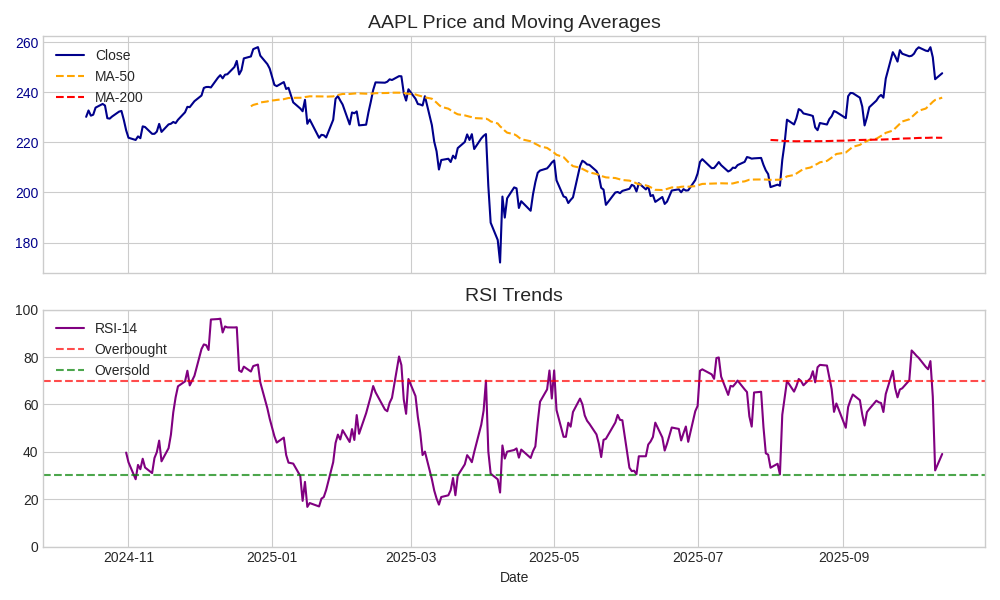

  Displaying: AAPL_CPIAUCSL_corr.png


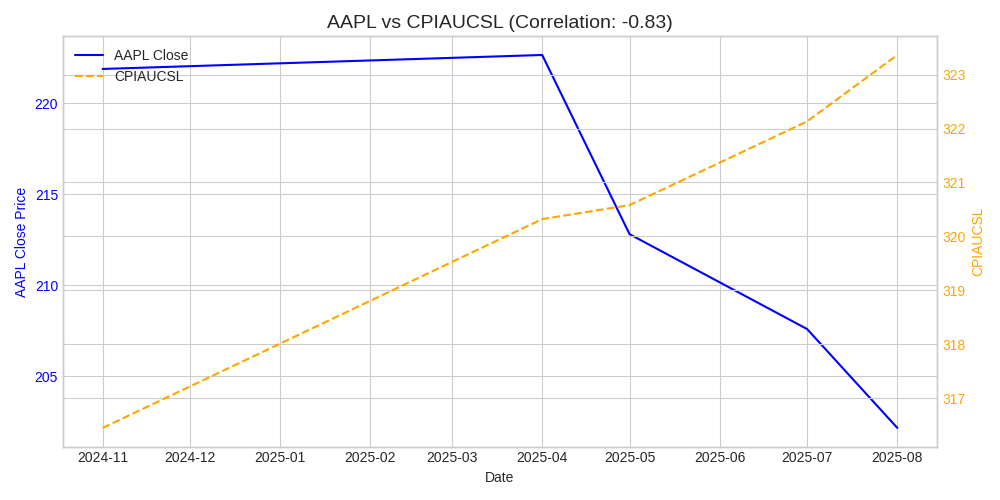

Your max_length is set to 150, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comprehensive Summary for AAPL
**Agent Confidence:** 0.5

**Key Analytical Insights:**
AAPL's RSI, key macro trends, and overall news sentiment are provided. Provide a comprehensive summary of AAPL's recent performance. Generate a concise analysis with a confidence score (0-1) and key insights. No prior analysis is required.

**Agent Data Conclusion:** *RSI is 39.08416606471194, Trend: Downtrend. CPI Correlation: -0.8345954491547297. Weighted News Sentiment: 0.00.*


--- 2. Risk Assessment Analysis ---
Enter Ticker for Risk Assessment (e.g., TSLA): MSFT
**TICKER RECEIVED:** MSFT. Running analysis...

Processing prompt: Analyze the investment risk for MSFT based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.
Analyzing MSFT...
    [Agent Learns] Prior Notes (None): No prior analysis
    [Tool Use] Fetching yfinance data for MS

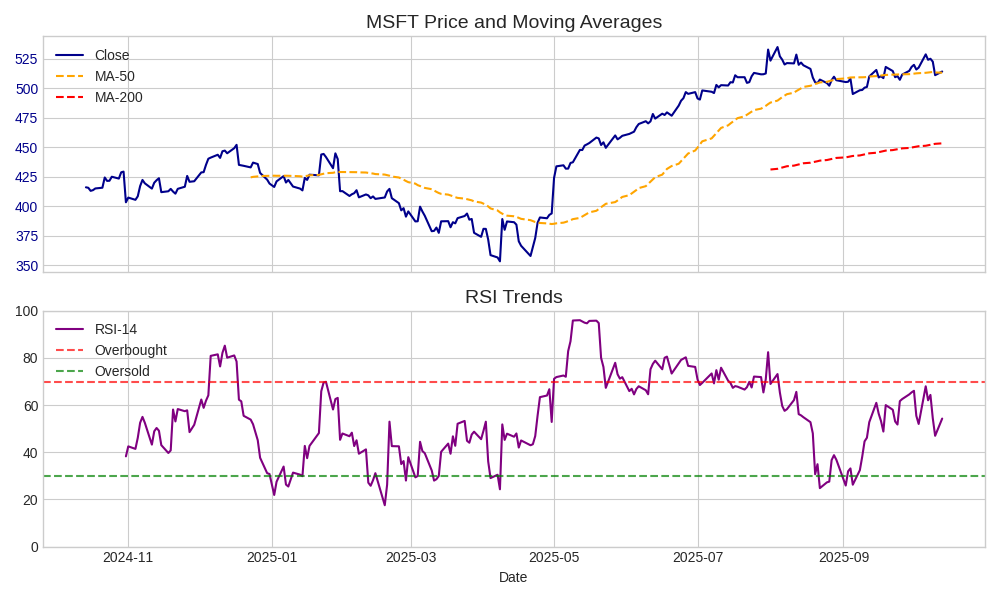

  Displaying: MSFT_CPIAUCSL_corr.png


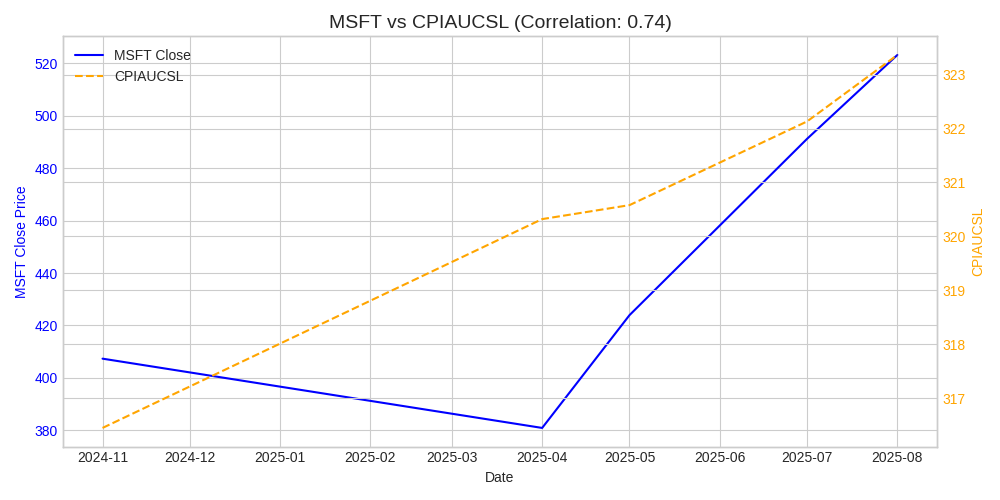

Your max_length is set to 150, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comprehensive Summary for MSFT
**Agent Confidence:** 0.5

**Key Analytical Insights:**
Analyze the investment risk for MSFT based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.Generate a concise analysis with a confidence score (0-1) and key insights.

**Agent Data Conclusion:** *RSI is 54.306622842680284, Trend: Downtrend. CPI Correlation: 0.741019899418371. Weighted News Sentiment: 0.00.*


--- 3. Comparison Analysis ---
Enter FIRST Ticker for Comparison (e.g., AAPL): AAPL
Enter SECOND Ticker for Comparison (e.g., MSFT): MSFT
**TICKERS RECEIVED:** AAPL and MSFT. Running comparison...

Processing prompt: Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them.
Analyzing AAPL...
    [Agent Learns] Prior Notes (2025-10-13 23:10:39.125180): No summary
    [T

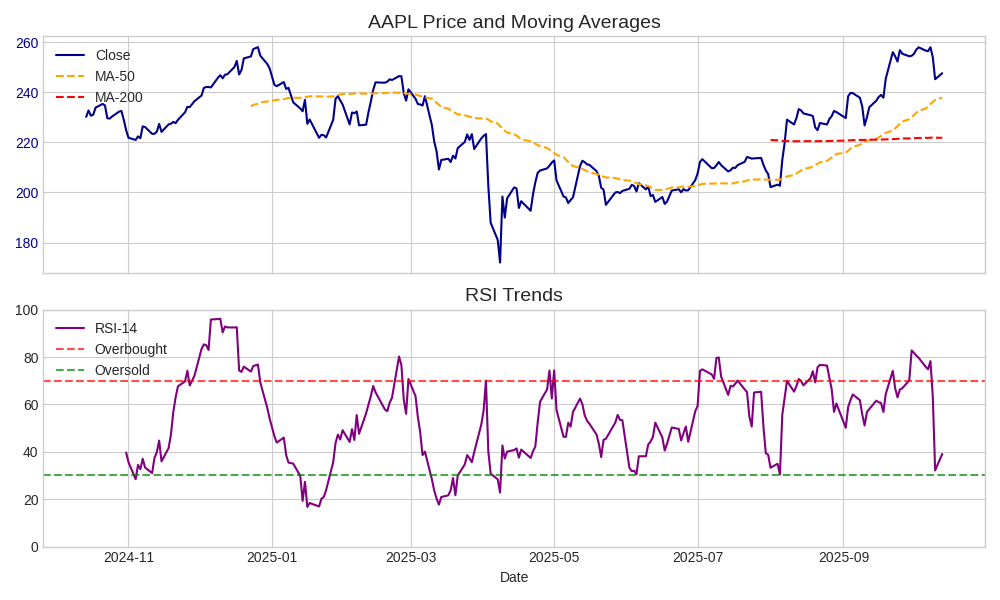

  Displaying: AAPL_CPIAUCSL_corr.png


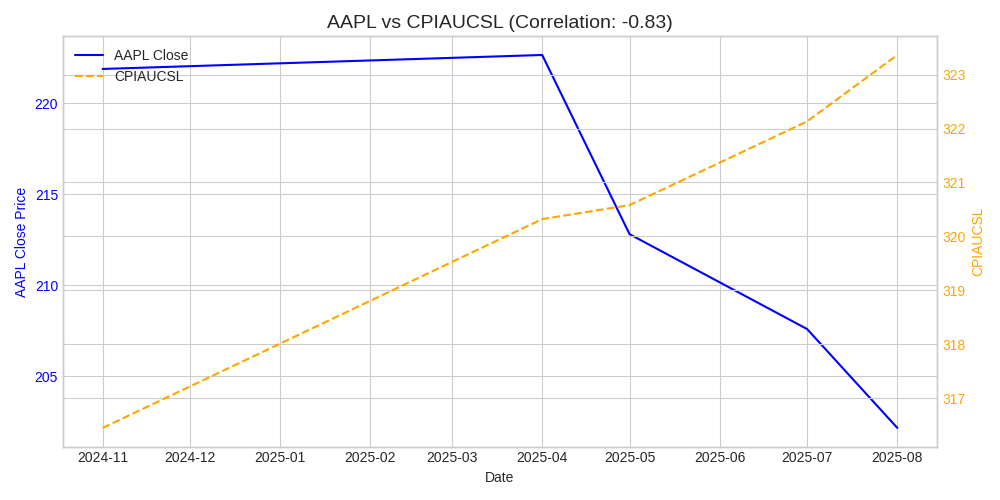


Analyzing MSFT...
    [Agent Learns] Prior Notes (2025-10-13 23:11:03.018187): No summary
    [Tool Use] Fetching yfinance data for MSFT...
        [Chart] Generated Macro Correlation chart: MSFT_CPIAUCSL_corr.png
    [Tool Use] Fetching yfinance data for MSFT...
        [Chart] Generated Price & RSI chart: MSFT_price_rsi.png

               📊 Final Investment Report for MSFT
💡 Key Findings:
  - Current RSI (14): 54.306622842680284, Regime: Downtrend
  - Macro Correlation (CPI): 0.741019989633746
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Data Summary: RSI is 54.306622842680284, Trend: Downtrend. CPI Correlation: 0.741019989633746. Weighted News Sentiment: 0.00.

📈 Visual Evidence:
  Displaying: MSFT_price_rsi.png


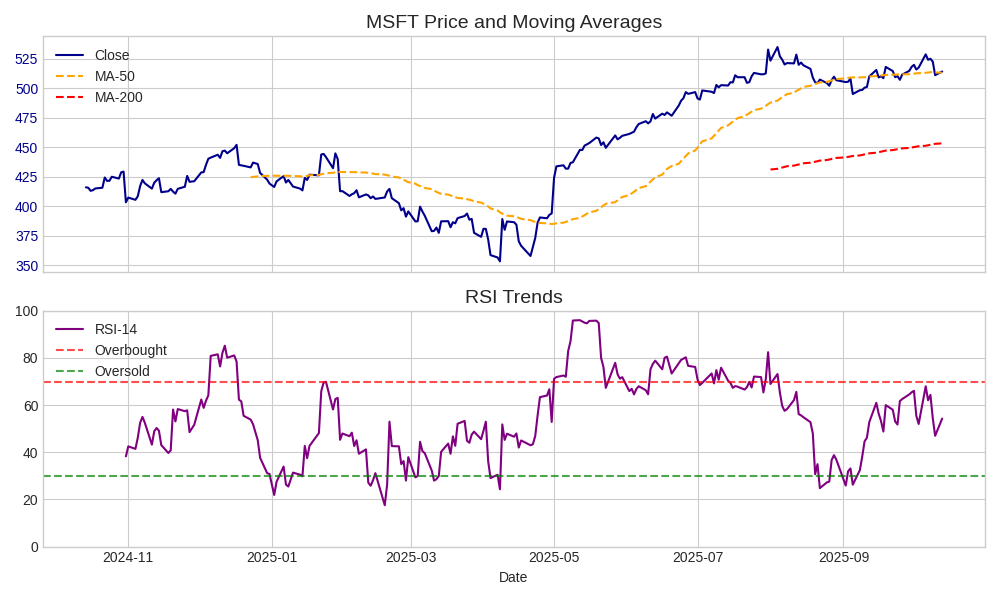

  Displaying: MSFT_CPIAUCSL_corr.png


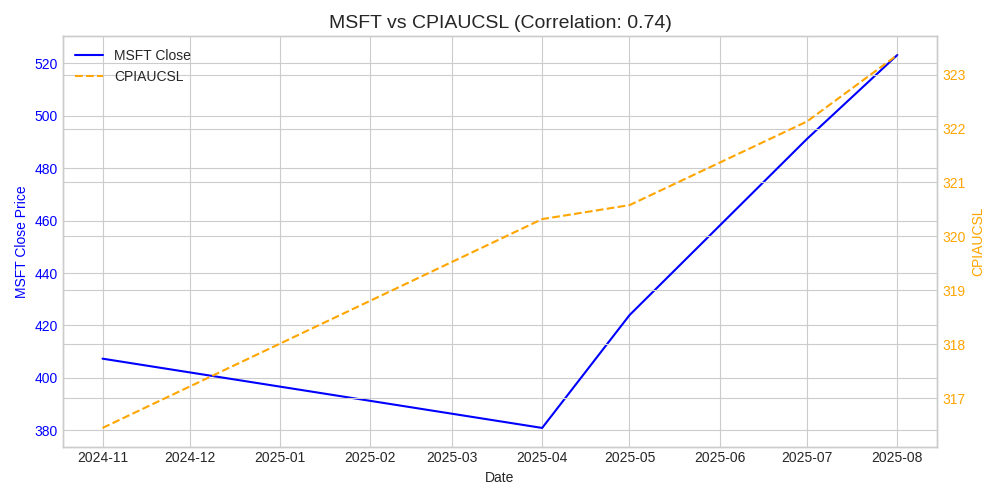

Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comparative Analysis: AAPL vs MSFT
**Query Intent:** Comparison (Address: *Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them.*)



,Metric,AAPL,MSFT
0,Agent Confidence,0.5,0.5
1,RSI (14),39.084166,54.306623
2,Price Regime,Downtrend,Downtrend
3,Macro Corr (CPI),-0.834596,0.74102
4,Weighted Sentiment,0,0



**Synthesis Conclusion:**
Compare the two tickers, provide a confidence score (0-1), and highlight strengths. Prompt: Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them. Compare the two stock tickers and provide an overview of their recent performance and recent risks. The results will be published on Friday, September 14. For confidential support call the Samaritans on 08457 90 90 90, visit a local Samaritans branch or click here for details.

📈 Visual Evidence:
  Displaying: AAPL_price_rsi.png


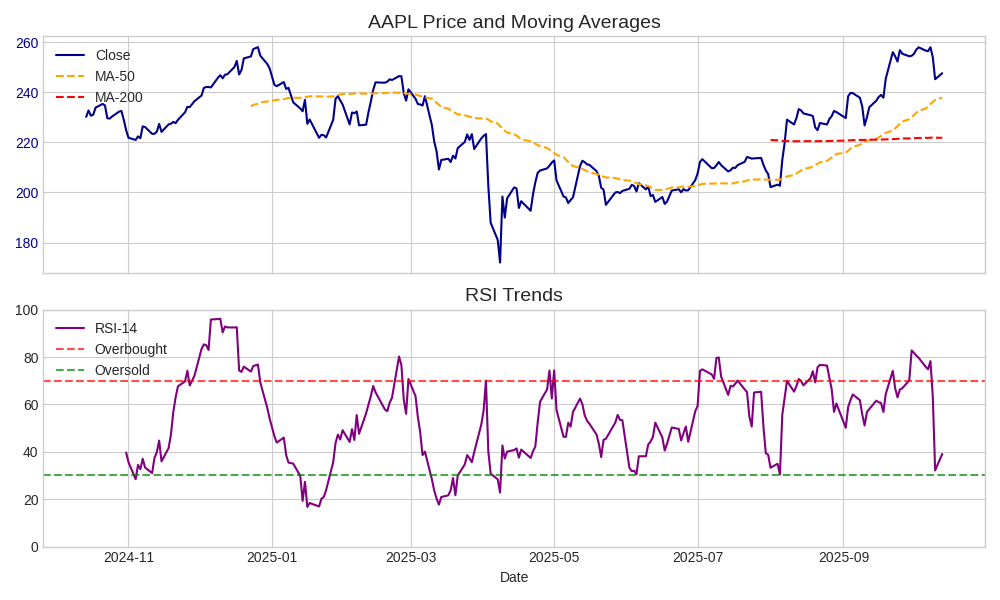

  Displaying: AAPL_CPIAUCSL_corr.png


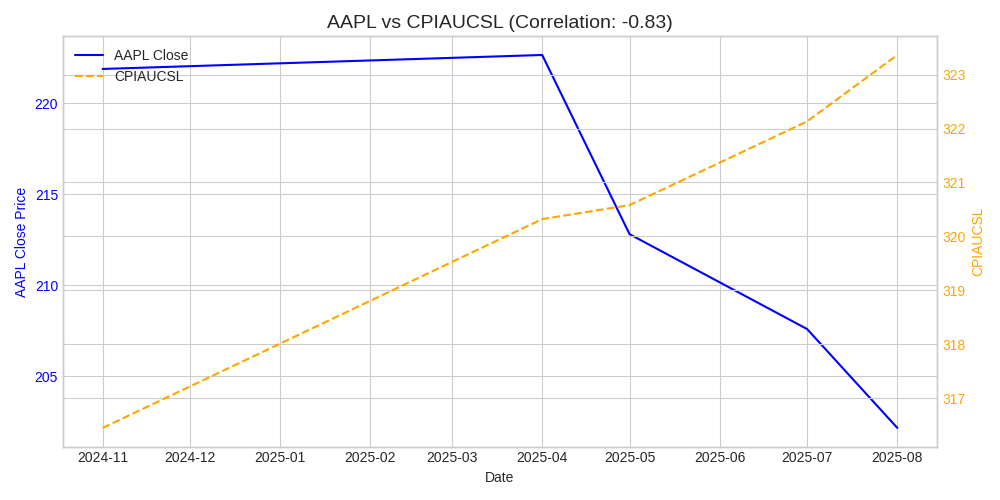

  Displaying: MSFT_price_rsi.png


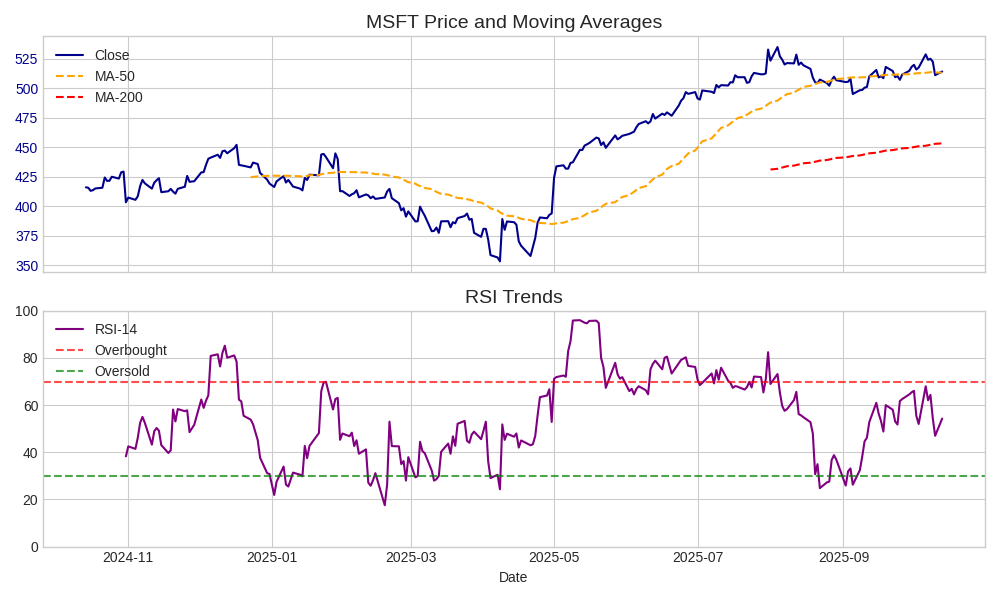

  Displaying: MSFT_CPIAUCSL_corr.png


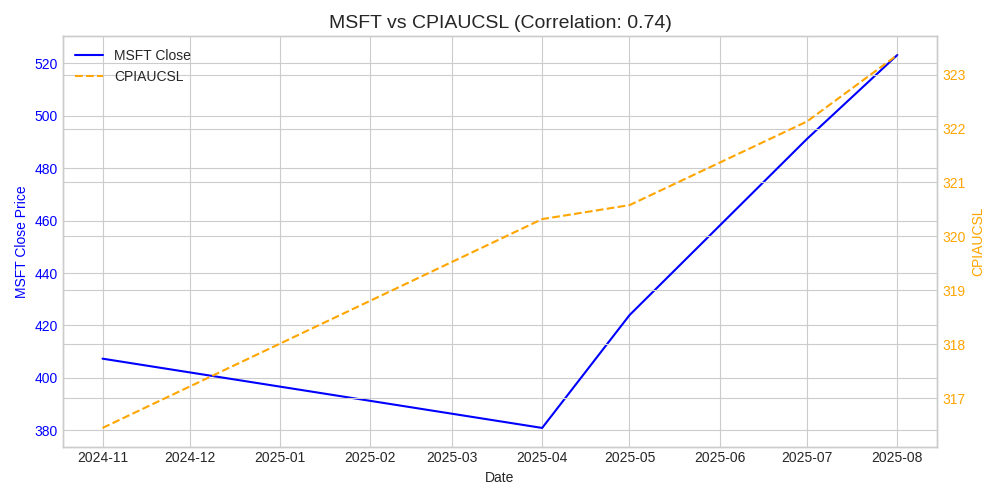



 INTERACTIVE MODE ENDED 


In [ ]:
# INTERACTIVE EXECUTION BLOCK

# Initialize the InvestmentResearchAgent
agent = InvestmentResearchAgent()

# Attach a PromptManager
agent.prompt_manager = PromptManager(agent)

print("\n" + "="*70)
print(" INVESTMENT AGENT INTERACTIVE MODE ")
print("Please enter the requested ticker symbol in the box that appears below each instruction.")
print("="*70)

# Interactive Example 1: Summary
print("\n--- 1. Summary Analysis ---")
user_ticker_summary = input("Enter Ticker for Summary (e.g., AAPL): ").upper()
if user_ticker_summary:
    print(f"**TICKER RECEIVED:** {user_ticker_summary}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        f"Provide a comprehensive summary of {user_ticker_summary}'s recent performance including its RSI, key macro trends, and overall news sentiment.",
        ticker=user_ticker_summary
    )
    time.sleep(1)

# Interactive Example 2: Risk Assessment
print("\n--- 2. Risk Assessment Analysis ---")
user_ticker_risk = input("Enter Ticker for Risk Assessment (e.g., TSLA): ").upper()
if user_ticker_risk:
    print(f"**TICKER RECEIVED:** {user_ticker_risk}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        f"Analyze the investment risk for {user_ticker_risk} based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.",
        ticker=user_ticker_risk
    )
    time.sleep(1)

# Interactive Example 3: Comparison
print("\n--- 3. Comparison Analysis ---")
user_ticker1_comp = input("Enter FIRST Ticker for Comparison (e.g., AAPL): ").upper()
user_ticker2_comp = input("Enter SECOND Ticker for Comparison (e.g., MSFT): ").upper()
if user_ticker1_comp and user_ticker2_comp:
    print(f"**TICKERS RECEIVED:** {user_ticker1_comp} and {user_ticker2_comp}. Running comparison...")
    agent.prompt_manager.execute_prompt(
        f"Compare {user_ticker1_comp} against {user_ticker2_comp} focusing on their investment performance, recent risks, and how news sentiment differs between them.",
        ticker=user_ticker1_comp,  # Corrected from ticker1 to ticker
        ticker2=user_ticker2_comp
    )

print("\n" + "="*70)
print(" INTERACTIVE MODE ENDED ")
print("="*70)

## Code Analysis
This is an Investment Research Agent that utilizes agentic AI to coordinate multiple specialized agents to handle complex financial tasks.

Data: The code pulls prices/news from yfinance and FRED, computes RSI, basic MA trends, and creates correlation plots.

Specialists: There are four agent classes: PriceAnalyzer, MacroAnalyzer, NewsAnalyzer, and NewsSummarizer.

Planning and Routing: SynthesisAgent and Prompt Manager orchestrate the run: loading memory --> fetching data --> run specialist agents --> summarize --> generate charts --> persist notes.

Self Reflection: The Evaluator Optimizeris found in the Agent Metrics & Reflection section.

Learning across runs: load_memory/save_memory persists a per ticker JSON with notes and timestamps.

RAG: a local RAGStore is used to build/reuse embedding index for news docs, pre-filter news, and provide context for news briefing for the News Summarizer

## Evaluation/Future Improvements
Evaluator-Optimizer could be more robust with re-prompting.
